
# Predicting "Biological Age" (or BMI) from Lifestyle

https://www.kaggle.com/datasets/ydalat/lifestyle-and-wellbeing-data


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import shap # shapley value 
import lightgbm as lgb


In [4]:
# Path to your CSV (change this to your local file path)
CSV_PATH = "Wellbeing_and_lifestyle_data_Kaggle.csv"  # <-- change to your actual CSV path

In [5]:
df = pd.read_csv(CSV_PATH)
df

,Timestamp,FRUITS_VEGGIES,DAILY_STRESS,PLACES_VISITED,CORE_CIRCLE,SUPPORTING_OTHERS,SOCIAL_NETWORK,ACHIEVEMENT,DONATION,BMI_RANGE,...,SLEEP_HOURS,LOST_VACATION,DAILY_SHOUTING,SUFFICIENT_INCOME,PERSONAL_AWARDS,TIME_FOR_PASSION,WEEKLY_MEDITATION,AGE,GENDER,WORK_LIFE_BALANCE_SCORE
0,7/7/15,3,2,2,5,0,5,2,0,1,...,7,5,5,1,4,0,5,36 to 50,Female,609.5
1,7/7/15,2,3,4,3,8,10,5,2,2,...,8,2,2,2,3,2,6,36 to 50,Female,655.6
2,7/7/15,2,3,3,4,4,10,3,2,2,...,8,10,2,2,4,8,3,36 to 50,Female,631.6
3,7/7/15,3,3,10,3,10,7,2,5,2,...,5,7,5,1,5,2,0,51 or more,Female,622.7
4,7/7/15,5,1,3,3,10,4,2,4,2,...,7,0,0,2,8,1,5,51 or more,Female,663.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15967,3/14/21 5:42,3,3,0,4,0,10,0,4,2,...,7,0,1,1,5,2,5,51 or more,Female,644.5
15968,3/14/21 6:30,3,3,6,8,7,4,6,3,1,...,6,0,0,2,10,5,8,21 to 35,Female,714.9
15969,3/14/21 8:35,4,3,0,10,10,8,6,5,1,...,7,0,1,2,10,1,10,21 to 35,Male,716.6
15970,3/14/21 8:43,1,1,10,8,2,7,3,2,1,...,8,7,2,2,1,6,8,21 to 35,Female,682.0


In [6]:
assert df.isna().sum().sum() == 0, "Data contains missing values!"

In [7]:
df.columns = [col.lower() for col in df.columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                15972 non-null  object 
 1   fruits_veggies           15972 non-null  int64  
 2   daily_stress             15972 non-null  object 
 3   places_visited           15972 non-null  int64  
 4   core_circle              15972 non-null  int64  
 5   supporting_others        15972 non-null  int64  
 6   social_network           15972 non-null  int64  
 7   achievement              15972 non-null  int64  
 8   donation                 15972 non-null  int64  
 9   bmi_range                15972 non-null  int64  
 10  todo_completed           15972 non-null  int64  
 11  flow                     15972 non-null  int64  
 12  daily_steps              15972 non-null  int64  
 13  live_vision              15972 non-null  int64  
 14  sleep_hours           

In [9]:
df.describe()

,fruits_veggies,places_visited,core_circle,supporting_others,social_network,achievement,donation,bmi_range,todo_completed,flow,daily_steps,live_vision,sleep_hours,lost_vacation,daily_shouting,sufficient_income,personal_awards,time_for_passion,weekly_meditation,work_life_balance_score
count,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000
mean,2.922677,5.232970,5.508077,5.616454,6.474267,4.000751,2.715314,1.410656,5.745993,3.194778,5.703606,3.752129,7.042888,2.898886,2.930879,1.728963,5.711558,3.326572,6.233346,666.751503
std,1.442694,3.311912,2.840334,3.242021,3.086672,2.755837,1.851586,0.491968,2.624097,2.357518,2.891013,3.230987,1.199044,3.692180,2.676301,0.444509,3.089630,2.729293,3.016571,45.019868
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,480.000000
25%,2.000000,2.000000,3.000000,3.000000,4.000000,2.000000,1.000000,1.000000,4.000000,1.000000,3.000000,1.000000,6.000000,0.000000,1.000000,1.000000,3.000000,1.000000,4.000000,636.000000
50%,3.000000,5.000000,5.000000,5.000000,6.000000,3.000000,3.000000,1.000000,6.000000,3.000000,5.000000,3.000000,7.000000,0.000000,2.000000,2.000000,5.000000,3.000000,7.000000,667.700000
75%,4.000000,8.000000,8.000000,10.000000,10.000000,6.000000,5.000000,2.000000,8.000000,5.000000,8.000000,5.000000,8.000000,5.000000,4.000000,2.000000,9.000000,5.000000,10.000000,698.500000
max,5.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,10.000000,10.000000,10.000000,820.200000


## Pandas profiling

In [ ]:
!uv pip install ydata_profiling

Using Python 3.11.13 environment at: c:\Users\hayk_\OneDrive\Desktop\01_python_math_ml_course\ma
Resolved 50 packages in 1.74s
Prepared 16 packages in 36.19s
Uninstalled 3 packages in 471ms
Installed 18 packages in 618ms
 + dacite==1.9.2
 + filetype==1.2.0
 + imagehash==4.3.1
 - llvmlite==0.45.1
 + llvmlite==0.44.0
 - matplotlib==3.10.6
 + matplotlib==3.10.0
 + minify-html==0.18.1
 + multimethod==1.12
 - numba==0.62.1
 + numba==0.61.0
 + patsy==1.0.2
 + phik==0.12.5
 + puremagic==1.30
 + pywavelets==1.9.0
 + seaborn==0.13.2
 + statsmodels==0.14.5
 + typeguard==4.4.4
 + visions==0.8.1
 + wordcloud==1.9.4
 + ydata-profiling==4.17.0


In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Health Data Profiling Report", explorative=True)

profile.to_file("health_data_profiling_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


In [8]:
df[df.duplicated()]

,timestamp,fruits_veggies,daily_stress,places_visited,core_circle,supporting_others,social_network,achievement,donation,bmi_range,...,sleep_hours,lost_vacation,daily_shouting,sufficient_income,personal_awards,time_for_passion,weekly_meditation,age,gender,work_life_balance_score
77,7/20/15,5,2,10,1,4,5,0,5,1,...,8,0,6,2,10,1,6,36 to 50,Female,694.0
82,7/20/15,0,5,0,2,0,0,3,0,2,...,6,10,10,1,2,1,10,21 to 35,Male,538.8
89,7/20/15,5,0,8,3,10,7,6,3,1,...,8,0,1,2,10,5,10,36 to 50,Female,749.7
115,7/23/15,5,2,10,7,4,3,5,2,1,...,9,8,3,2,10,5,10,Less than 20,Female,709.4
120,7/24/15,1,2,6,8,4,5,2,1,1,...,10,0,3,2,1,2,4,21 to 35,Female,665.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10475,3/14/19 3:28,3,3,6,9,6,7,8,3,1,...,6,4,6,1,8,7,10,Less than 20,Female,696.6
12414,1/18/20 7:59,2,4,5,3,3,4,0,5,2,...,6,0,9,1,1,2,2,21 to 35,Female,594.6
12758,2/25/20 3:12,4,5,3,6,4,10,1,5,2,...,7,4,7,1,2,1,2,36 to 50,Female,600.4
14014,7/20/20 18:02,5,3,6,3,6,10,6,2,1,...,7,10,3,1,6,2,4,21 to 35,Male,658.1


In [10]:
len(df[df.duplicated()]) / len(df)

0.030177811169546705

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df["timestamp"].value_counts()

timestamp
7/23/18          162
3/22/16          136
5/29/18          112
8/13/18           48
9/7/15            39
                ... 
11/5/19 8:21       1
11/5/19 0:27       1
11/4/19 23:20      1
11/4/19 19:32      1
3/14/21 9:03       1
Name: count, Length: 7002, dtype: int64

In [13]:
COLS_TO_DROP = ["timestamp"]

df.drop(columns=COLS_TO_DROP, inplace=True)

In [14]:
age_mapping = {
    "Less than 20": 18,
    "21 to 35": (21 + 35) / 2,
    "36 to 50": (36 + 50) / 2,
    "51 or more": 65
}

df["age"] = df["age"].map(age_mapping)

In [15]:
df.corr()

ValueError: could not convert string to float: '1/1/00'

In [15]:
df.columns

Index(['fruits_veggies', 'daily_stress', 'places_visited', 'core_circle',
       'supporting_others', 'social_network', 'achievement', 'donation',
       'bmi_range', 'todo_completed', 'flow', 'daily_steps', 'live_vision',
       'sleep_hours', 'lost_vacation', 'daily_shouting', 'sufficient_income',
       'personal_awards', 'time_for_passion', 'weekly_meditation', 'age',
       'gender', 'work_life_balance_score'],
      dtype='object')

In [16]:
val = "1/1/00"

for col in df.columns:
    if df[col].dtype == "object":
        unique_values = df[col].unique()
        if val in unique_values:
            print(f"Column '{col}' contains the value '{val}'")

Column 'daily_stress' contains the value '1/1/00'


In [17]:
df["daily_stress"].value_counts()

daily_stress
3         4230
2         3302
4         2903
1         2409
5         1987
0          658
1/1/00       1
Name: count, dtype: int64

In [18]:
df[df["daily_stress"] == "1/1/00"]

,fruits_veggies,daily_stress,places_visited,core_circle,supporting_others,social_network,achievement,donation,bmi_range,todo_completed,...,sleep_hours,lost_vacation,daily_shouting,sufficient_income,personal_awards,time_for_passion,weekly_meditation,age,gender,work_life_balance_score
10005,3,1/1/00,1,2,10,10,5,5,2,6,...,6,10,1,2,10,8,2,28.0,Male,682.6


In [19]:
df = df[df["daily_stress"] != "1/1/00"]

In [20]:
df.corr()

ValueError: could not convert string to float: 'Female'

In [21]:
df["gender"] = df["gender"].map({
    "Male": 1,
    "Female": 0
})

In [22]:
def get_correlation_matrix_and_heatmap(corr_type='pearson'):
    corr_matrix = df.corr(method=corr_type)
    
    np.fill_diagonal(corr_matrix.values, 0)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm')
    plt.colorbar()
    plt.show()
    
    return corr_matrix

In [24]:
def get_highly_correlated_features(corr_matrix, threshold=0.7):
    correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname_i = corr_matrix.columns[i]
                colname_j = corr_matrix.columns[j]
                correlated_pairs.append((colname_i, colname_j, corr_matrix.iloc[i, j]))
    return correlated_pairs

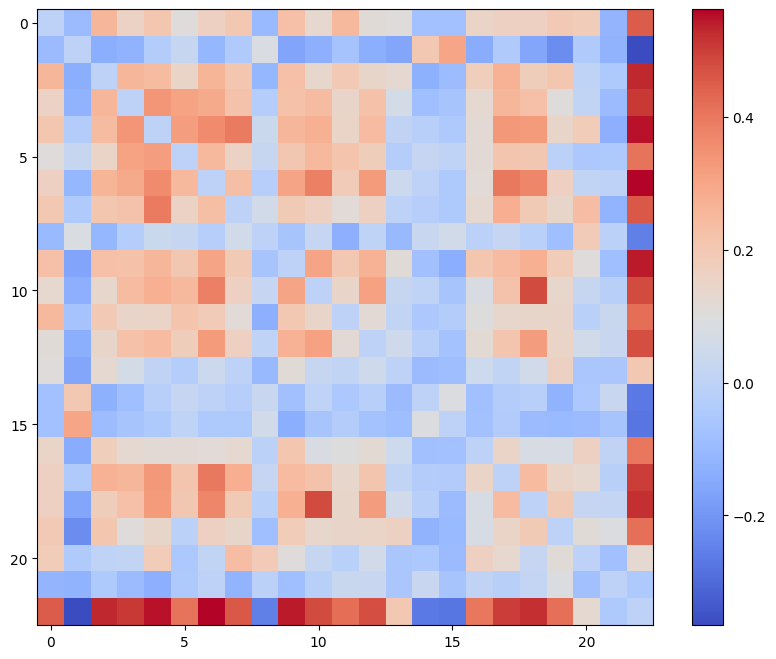

[('work_life_balance_score', 'places_visited', 0.529693218214423),
 ('work_life_balance_score', 'core_circle', 0.5081126540629171),
 ('work_life_balance_score', 'supporting_others', 0.5507058507073569),
 ('work_life_balance_score', 'achievement', 0.5621998704278968),
 ('work_life_balance_score', 'todo_completed', 0.5437613024968656),
 ('work_life_balance_score', 'personal_awards', 0.503270619962879),
 ('work_life_balance_score', 'time_for_passion', 0.5191691934231382)]

In [25]:
corr_matrix = get_correlation_matrix_and_heatmap(corr_type='pearson')

get_highly_correlated_features(corr_matrix, threshold=0.5)

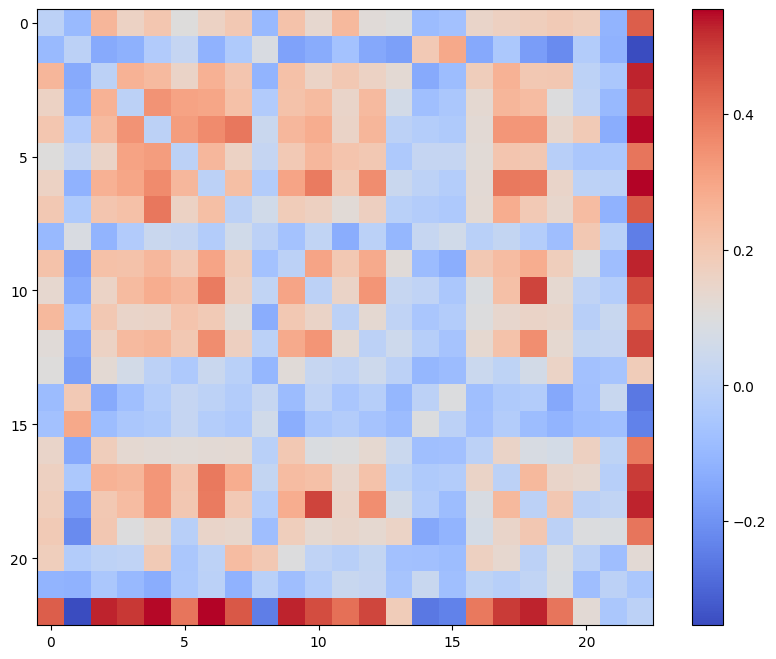

[('work_life_balance_score', 'places_visited', 0.5293314808895304),
 ('work_life_balance_score', 'core_circle', 0.5033945343098842),
 ('work_life_balance_score', 'supporting_others', 0.5496540112780857),
 ('work_life_balance_score', 'achievement', 0.5546180274579711),
 ('work_life_balance_score', 'todo_completed', 0.5285993870807436),
 ('work_life_balance_score', 'time_for_passion', 0.5279178958716718)]

In [26]:
corr_matrix = get_correlation_matrix_and_heatmap(corr_type='spearman')

get_highly_correlated_features(corr_matrix, threshold=0.5)

## 2) Train/Val/Test split

In [51]:
df.columns

Index(['fruits_veggies', 'daily_stress', 'places_visited', 'core_circle',
       'supporting_others', 'social_network', 'achievement', 'donation',
       'bmi_range', 'todo_completed', 'flow', 'daily_steps', 'live_vision',
       'sleep_hours', 'lost_vacation', 'daily_shouting', 'sufficient_income',
       'personal_awards', 'time_for_passion', 'weekly_meditation', 'age',
       'gender', 'work_life_balance_score'],
      dtype='object')

# Target

<Axes: >

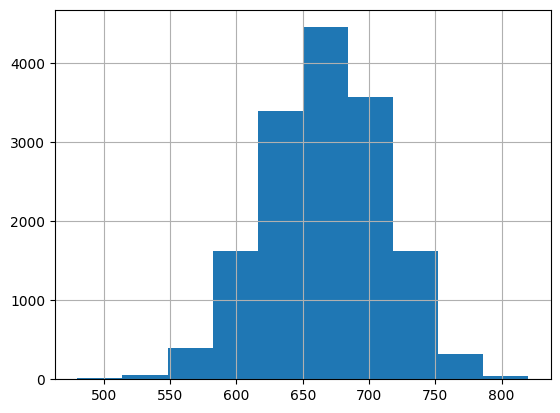

In [27]:
y = "work_life_balance_score"

df[y].hist()

In [ ]:
for col in df.columns:
    if col != y:
        plt.figure()
        plt.scatter(df[col], df[y])
        plt.xlabel(col)
        plt.ylabel(y)
        plt.title(f"{col} vs {y}")
        plt.show()

In [28]:
# Drop target and do 80-10-10 split
X = df.drop(columns=[y])
y_data = df[y]

# First split: 80% train, 20% temp (which will be split into 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_data, test_size=0.2, random_state=509
)

# Second split: split the 20% temp into 10% val and 10% test (50-50 split of temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=509
)

print(f"Train set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

Train set: 12391 samples (80.0%)
Val set: 1549 samples (10.0%)
Test set: 1549 samples (10.0%)


In [29]:
# save test data and labels for later use
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

del X_test, y_test

In [30]:
X_test

NameError: name 'X_test' is not defined

## Modeling

### Super conservative baseline (Optimal Constant Model)

In [39]:
# Constant mean predictor - predict mean of training set
mean_prediction = y_train.mean()

# Make predictions on validation set
y_val_pred = np.full(len(y_val), mean_prediction)

# Calculate metrics
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

print("=" * 60)
print("BASELINE MODEL: Constant Mean Predictor")
print("=" * 60)
print(f"Training mean: {mean_prediction:.2f}")
print(f"\nValidation Set Performance:")
print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²:   {r2:.4f}")
print("=" * 60)

BASELINE MODEL: Constant Mean Predictor
Training mean: 666.45

Validation Set Performance:
  MAE:  35.84
  RMSE: 43.96
  R²:   -0.0006


### LightGBM

In [46]:
# Train LightGBM model
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31 // 4,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 509
}

print("Training LightGBM model...")
lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1_000 * 2,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'val'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)



Training LightGBM model...
Training until validation scores don't improve for 50 rounds


[100]	train's rmse: 9.38673	val's rmse: 9.60176
[200]	train's rmse: 4.60738	val's rmse: 4.95187
[300]	train's rmse: 3.6195	val's rmse: 3.95198
[400]	train's rmse: 3.18431	val's rmse: 3.50439
[500]	train's rmse: 2.91974	val's rmse: 3.22468
[600]	train's rmse: 2.73751	val's rmse: 3.0422
[700]	train's rmse: 2.59075	val's rmse: 2.89636
[800]	train's rmse: 2.47241	val's rmse: 2.78021
[900]	train's rmse: 2.38421	val's rmse: 2.69856
[1000]	train's rmse: 2.2993	val's rmse: 2.62934
[1100]	train's rmse: 2.21925	val's rmse: 2.56331
[1200]	train's rmse: 2.14647	val's rmse: 2.49791
[1300]	train's rmse: 2.08061	val's rmse: 2.43876
[1400]	train's rmse: 2.02362	val's rmse: 2.3931
[1500]	train's rmse: 1.9707	val's rmse: 2.35185
[1600]	train's rmse: 1.92033	val's rmse: 2.30956
[1700]	train's rmse: 1.87122	val's rmse: 2.2738
[1800]	train's rmse: 1.82991	val's rmse: 2.2373
[1900]	train's rmse: 1.78897	val's rmse: 2.20872
[2000]	train's rmse: 1.73837	val's rmse: 2.16622
Did not meet early stopping. Best it

In [ ]:
# [1000]	train's rmse: 2.16335	val's rmse: 2.72377
# [2000]	train's rmse: 1.73837	val's rmse: 2.16622

In [41]:
df["daily_stress"] = df["daily_stress"].astype(float)

X_train["daily_stress"] = X_train["daily_stress"].astype(float)
X_val["daily_stress"] = X_val["daily_stress"].astype(float)

## Evaluation

In [47]:
def evaluate_regression(actual, predictions,
    model_name=None, filename=None, notes=None,
    return_metrics=False, show_plots=False,
    show_metrics=True, plots=False, round_digits=3):
    """
    Function to evaluate a regression model.

    .. warning::
        Assumes that ``scipy``, ``sklearn``, and ``matplotlib`` are installed
        in your environment.

    This function:
        - Prints R2, MAE, MSE, RMSE metrics.
        - Prints Kendall's tau, Pearson's R, Spearman's rho correlation metrics.
        - Plots actual vs. predicted values.
        - Plots residuals vs. predicted values.
        - Plots distribution of residuals.
        - Plots predicted vs. actual distribution.
        - Saves results to file (if specified).
        - Returns metrics as a dictionary (if specified).
    Args:
        actual (array-like): Ground-truth target values.
        predictions (array-like): Model predictions.
        model_name (str, optional): Name of the model (for display/record-keeping).
        filename (str, optional): Path to an HTML file to save the results.
        notes (str, optional): Additional notes to include in the saved file (if `filename` is provided).
        return_metrics (bool, optional): If True, returns a dictionary of metrics. Defaults to False.
        show_plots (bool, optional): If True, calls `plt.show()` for each figure. Defaults to False.
        show_metrics (bool, optional): If True, prints the metrics and correlations to stdout. Defaults to True.
        plots (bool, optional): If True, generates plots. Defaults to False.
        round_digits (int, optional): Number of digits to round the metrics. Defaults to 3.

    Returns:
        dict or None: 
            A dictionary of computed metrics if `return_metrics=True`, otherwise None.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    from scipy.stats import kendalltau, pearsonr, spearmanr
    from datetime import datetime
    from io import BytesIO
    import base64
    # Ensure inputs are NumPy arrays
    actual = np.array(actual)
    predictions = np.array(predictions)

    def save_figure_to_file(fig):
        """
        Helper function:
        Convert a Matplotlib figure to a base64-encoded PNG for embedding in HTML.
        """
        tmpfile = BytesIO()
        fig.savefig(tmpfile, format='png')
        encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
        return encoded

    # 1. Calculate regression metrics
    r2 = round(r2_score(actual, predictions), round_digits)
    mae = round(mean_absolute_error(actual, predictions), round_digits)
    mape = round(mean_absolute_percentage_error(actual, predictions), round_digits)
    mse = round(mean_squared_error(actual, predictions), round_digits)
    rmse = round(np.sqrt(mean_squared_error(actual, predictions)), round_digits)

    # 2. Calculate correlation metrics
    pearson = round(pearsonr(actual, predictions)[0], round_digits)
    spearman = round(spearmanr(actual, predictions)[0], round_digits)
    kendall = round(kendalltau(actual, predictions)[0], round_digits)

    # 3. Print metrics if needed
    if show_metrics:
        print(f"Model: {model_name or 'N/A'}")
        print(f"R2: {r2}")
        print(f"MAE: {mae}")
        print(f"MAPE: {mape}")
        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"Pearson Correlation: {pearson}")
        print(f"Spearman Rho: {spearman}")
        print(f"Kendall Tau: {kendall}")

    # 4. Generate plots if requested
    if plots:
        residuals = actual - predictions

        # (a) Predicted vs. Actual
        fig1 = plt.figure()
        plt.scatter(actual, predictions, edgecolor='k', alpha=0.7)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Predicted vs. Actual")
        # add a diagonal line
        plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2)
        if show_plots:
            plt.show()
        prediction_vs_actual = save_figure_to_file(fig1)
        plt.close(fig1)

        # (b) Residuals vs. Predicted
        fig2 = plt.figure()
        plt.scatter(predictions, residuals, edgecolor='k', alpha=0.7)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel("Predicted")
        plt.ylabel("Residual")
        plt.title("Residuals vs. Predicted")
        if show_plots:
            plt.show()
        residuals_vs_predicted = save_figure_to_file(fig2)
        plt.close(fig2)

        # (c) Distribution of Residuals
        fig3 = plt.figure()
        plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
        plt.xlabel("Residual")
        plt.ylabel("Count")
        plt.title("Distribution of Residuals")
        if show_plots:
            plt.show()
        residuals_distribution = save_figure_to_file(fig3)
        plt.close(fig3)

        # (d) Distribution of Predicted vs. Actual
        fig4 = plt.figure()
        plt.hist(actual, bins=30, alpha=0.5, label="Actual", edgecolor='k')
        plt.hist(predictions, bins=30, alpha=0.5, label="Predicted", edgecolor='k')
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.title("Distribution of Predicted vs. Actual")
        plt.legend()
        if show_plots:
            plt.show()
        predicted_vs_actual_distribution = save_figure_to_file(fig4)
        plt.close(fig4)

    # 5. Save results to file (HTML) if requested
    if filename:
        with open(filename, "w") as f:
            f.write(f"<html><body>\n")
            f.write(f"<h2>Report generated: {datetime.now()}</h2>\n")
            if model_name:
                f.write(f"<h2>Model Name: {model_name}</h2>\n")

            if notes:
                f.write(f"<h3>Notes:</h3>\n<p>{notes}</p>\n")

            f.write("<h3>Metrics</h3>\n")
            f.write(f"<b>R2:</b> {r2} <br>\n")
            f.write(f"<b>MAE:</b> {mae} <br>\n")
            f.write(f"<b>MAPE:</b> {mape} <br>\n")
            f.write(f"<b>MSE:</b> {mse} <br>\n")
            f.write(f"<b>RMSE:</b> {rmse} <br>\n")

            f.write("<h3>Correlations</h3>\n")
            f.write(f"Pearson: {pearson} <br>\n")
            f.write(f"Spearman: {spearman} <br>\n")
            f.write(f"Kendall Tau: {kendall} <br>\n")

            if plots:
                f.write("<h3>Plots</h3>\n")
                f.write(f'<img src="data:image/png;base64,{prediction_vs_actual}"><br><br>\n')
                f.write(f'<img src="data:image/png;base64,{residuals_vs_predicted}"><br><br>\n')
                f.write(f'<img src="data:image/png;base64,{residuals_distribution}"><br><br>\n')
                f.write(f'<img src="data:image/png;base64,{predicted_vs_actual_distribution}"><br><br>\n')

            f.write("</body></html>\n")

    # 6. Optionally return a dictionary of metrics
    if return_metrics:
        return {
            "model_name": model_name,
            "notes": notes,
            "r2": r2,
            "mae": mae,
            "mape": mape,
            "mse": mse,
            "rmse": rmse,
            "pearson": pearson,
            "spearman": spearman,
            "kendall": kendall
        }

In [48]:
y_pred_train = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
y_pred_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

Model: LightGBM - Train Set
R2: 0.999
MAE: 1.376
MAPE: 0.002
MSE: 3.022
RMSE: 1.738
Pearson Correlation: 0.999
Spearman Rho: 0.999
Kendall Tau: 0.976


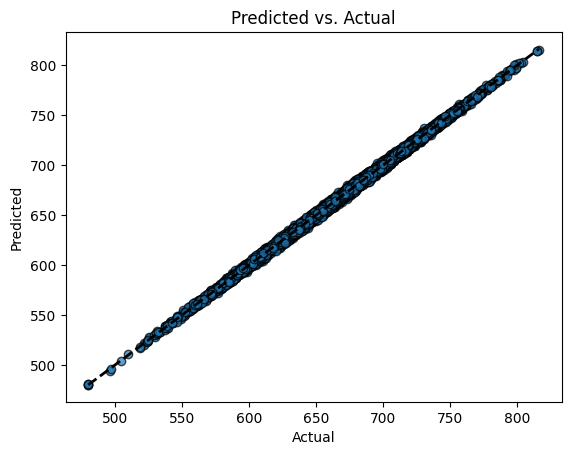

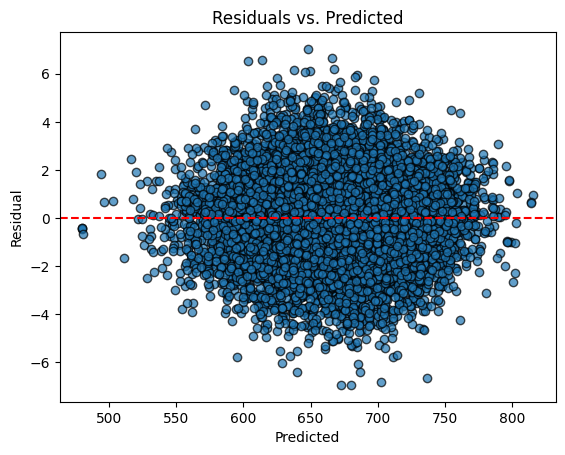

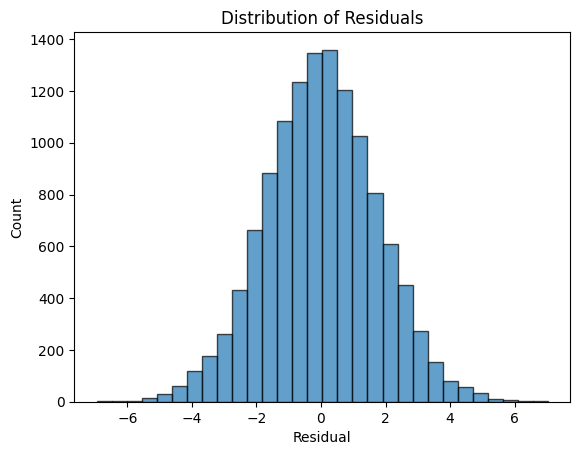

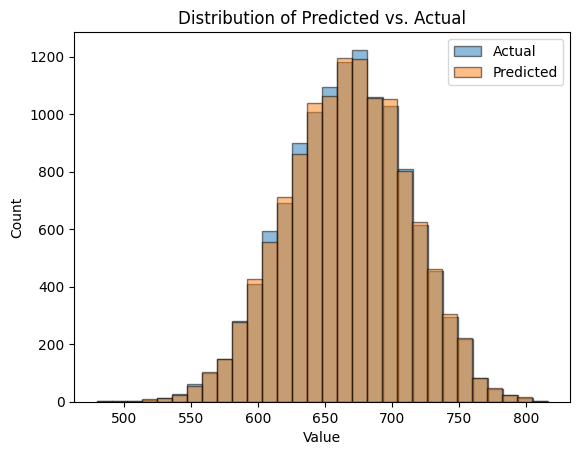

Model: LightGBM - Validation Set
R2: 0.998
MAE: 1.729
MAPE: 0.003
MSE: 4.693
RMSE: 2.166
Pearson Correlation: 0.999
Spearman Rho: 0.999
Kendall Tau: 0.97


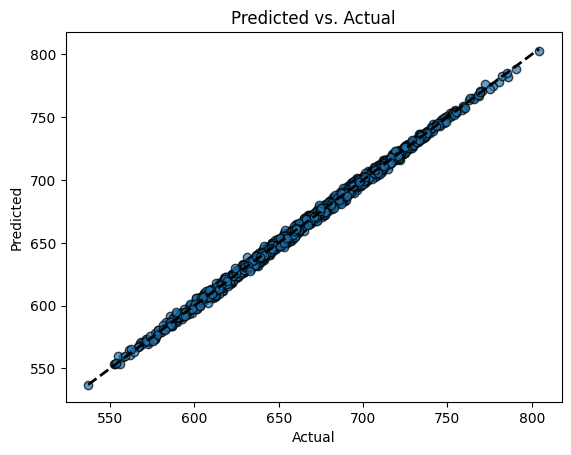

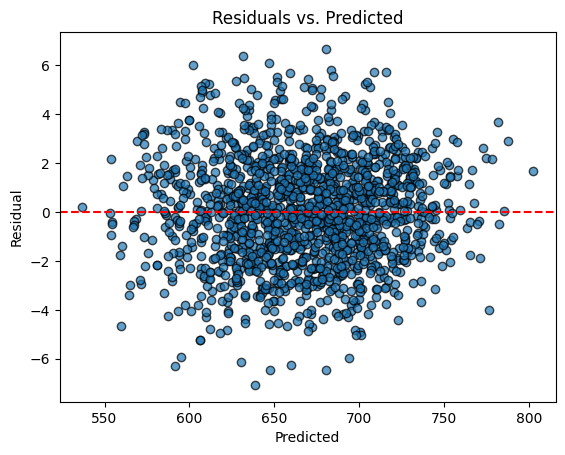

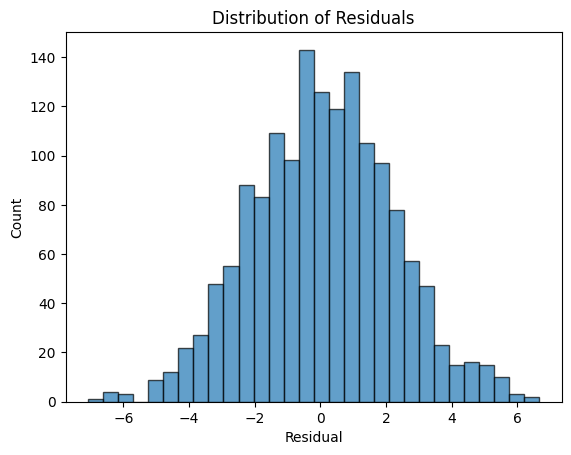

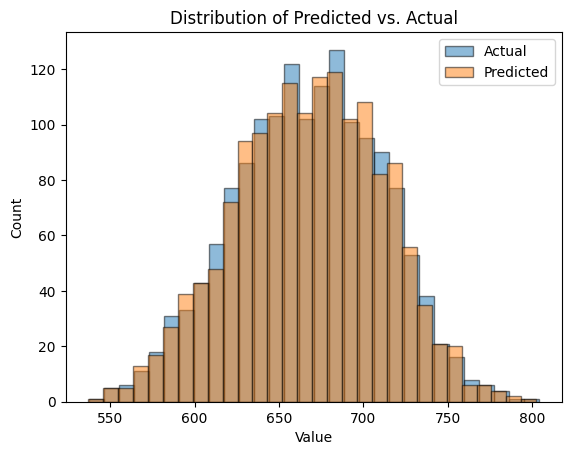

In [51]:
res_lgbm_train = evaluate_regression(y_train, y_pred_train,
    model_name="LightGBM - Train Set", show_plots=True, return_metrics=True, plots=True, )

res_lgbm_val = evaluate_regression(y_val, y_pred_val,
    model_name="LightGBM - Validation Set", show_plots=True, return_metrics=True, plots=True)


In [50]:
# print two results side by side for comparison in a table
results_df = pd.DataFrame({
    "Metric": list(res_lgbm_train.keys()),  # skip model_name and notes
    "Train Set": list(res_lgbm_train.values()),
    "Validation Set": list(res_lgbm_val.values())
})

results_df

,Metric,Train Set,Validation Set
0,model_name,LightGBM - Train Set,LightGBM - Validation Set
1,notes,None,None
2,r2,0.999,0.998
3,mae,1.376,1.729
4,mape,0.002,0.003
5,mse,3.022,4.693
6,rmse,1.738,2.166
7,pearson,0.999,0.999
8,spearman,0.999,0.999
9,kendall,0.976,0.97



## 4) SHAP explanations
https://slds-lmu.github.io/iml/chapters/

https://shap.readthedocs.io/en/latest/

In [56]:
2**100

1267650600228229401496703205376

Feature Importance (mean absolute SHAP values):


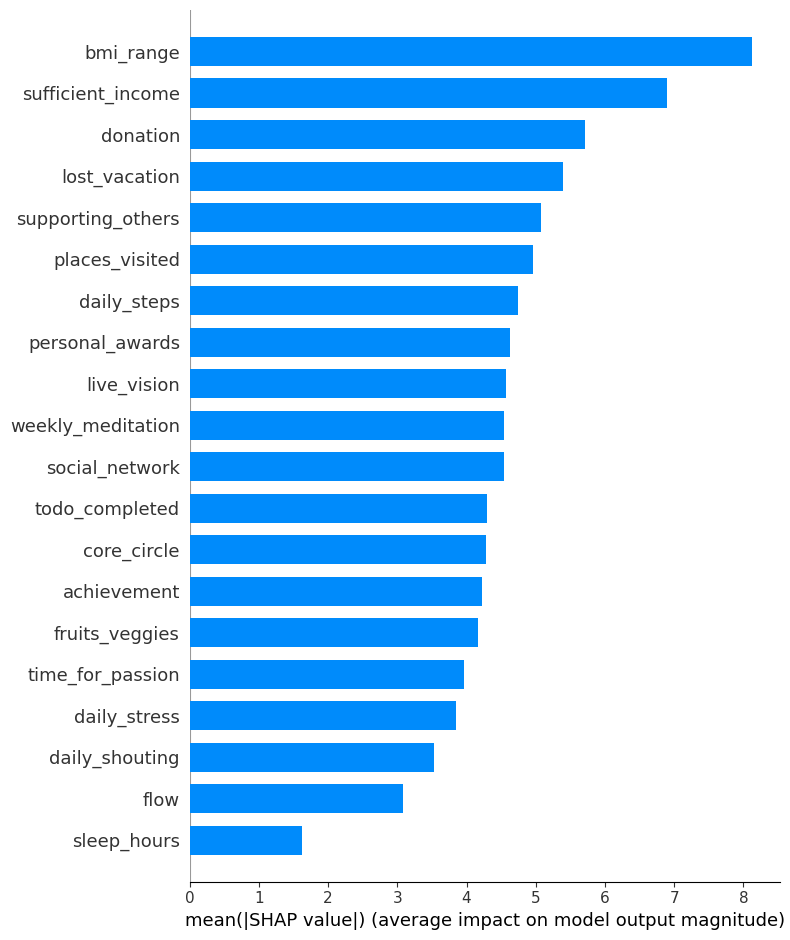

In [ ]:
# Create SHAP explainer for LightGBM model
explainer = shap.TreeExplainer(lgb_model)

# Calculate SHAP values for training set
shap_values_train = explainer.shap_values(X_train)

# Calculate SHAP values for validation set
shap_values_val = explainer.shap_values(X_val)



In [ ]:
# Summary plot (bar) - feature importance
print("Feature Importance (mean absolute SHAP values):")
shap.summary_plot(shap_values_val, X_val, plot_type="bar", show=False)
plt.tight_layout()
plt.show()



Feature Effects (beeswarm plot):


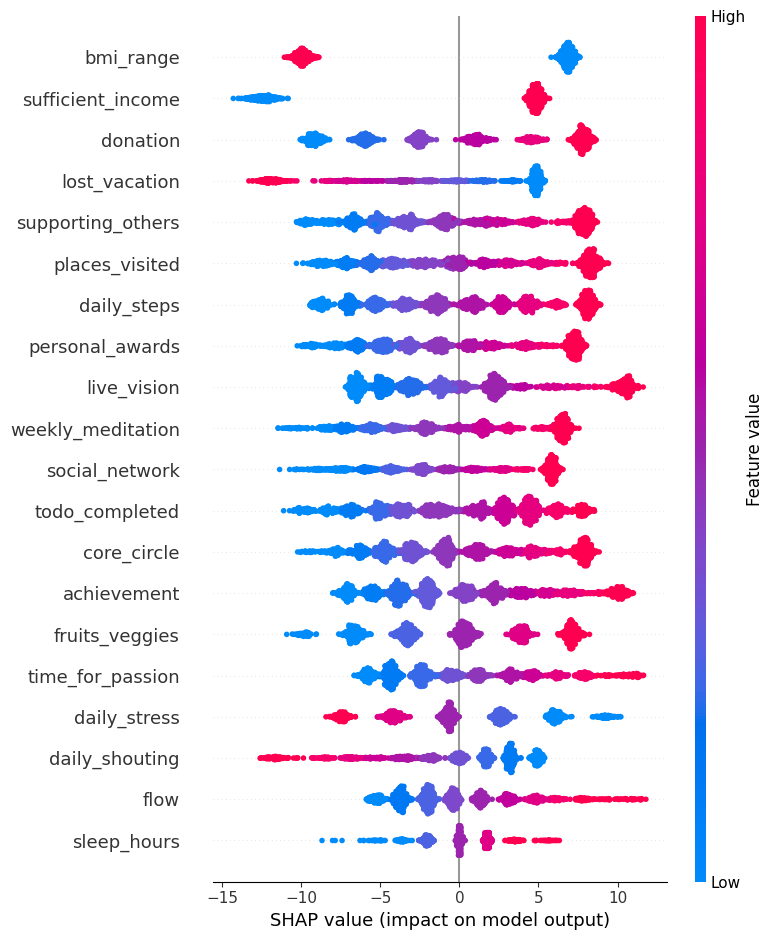

In [53]:

# Summary plot (beeswarm) - feature effects
print("\nFeature Effects (beeswarm plot):")
shap.summary_plot(shap_values_val, X_val, show=False)
plt.tight_layout()
plt.show()




Waterfall plot for first validation sample:


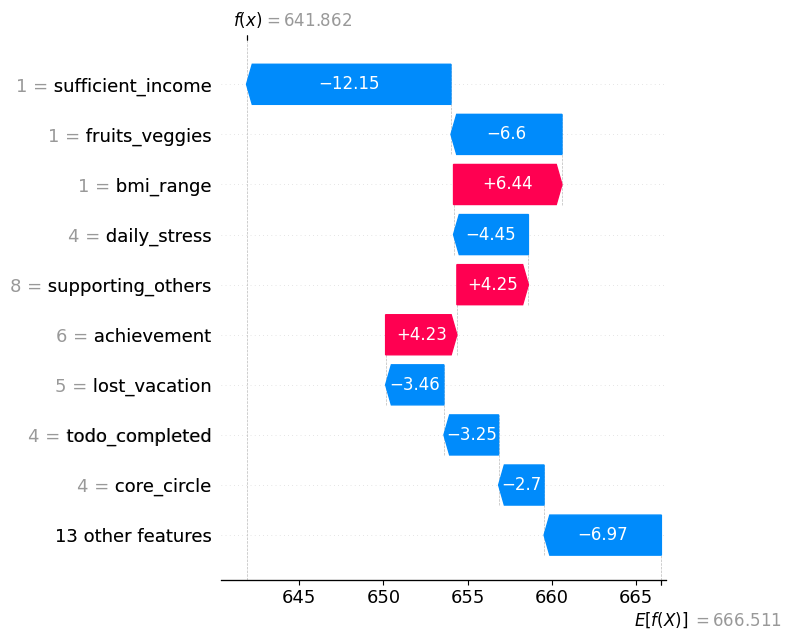

In [58]:
# Waterfall plot for first sample
print("\nWaterfall plot for first validation sample:")
shap.waterfall_plot(shap.Explanation(values=shap_values_val[1], 
                                      base_values=explainer.expected_value, 
                                      data=X_val.iloc[1], 
                                      feature_names=X_val.columns.tolist()),
                    show=False)
plt.tight_layout()
plt.show()



Dependence plots for top 5 features: ['bmi_range', 'sufficient_income', 'donation', 'lost_vacation', 'supporting_others']


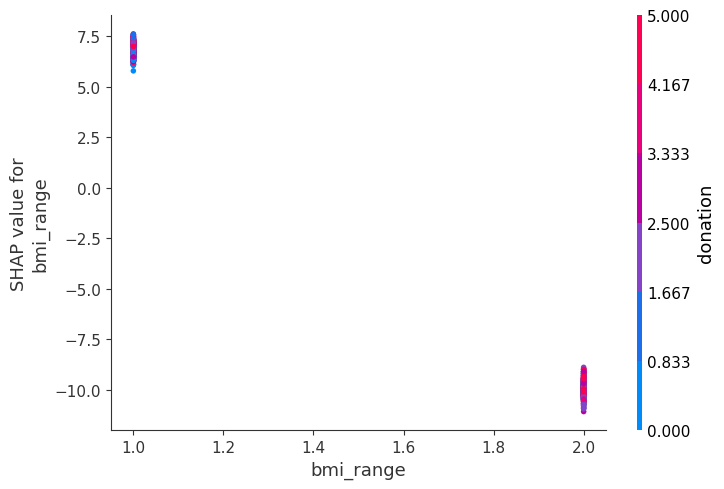

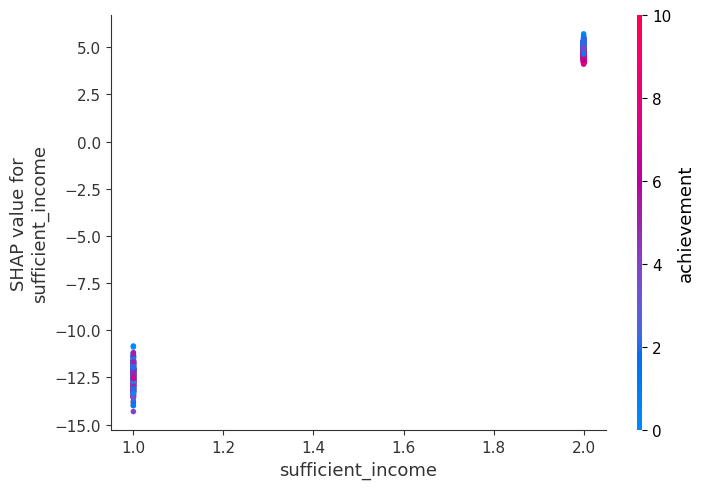

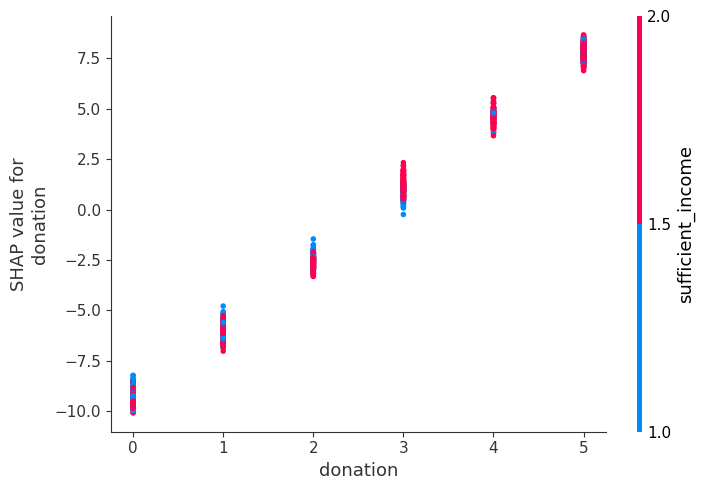

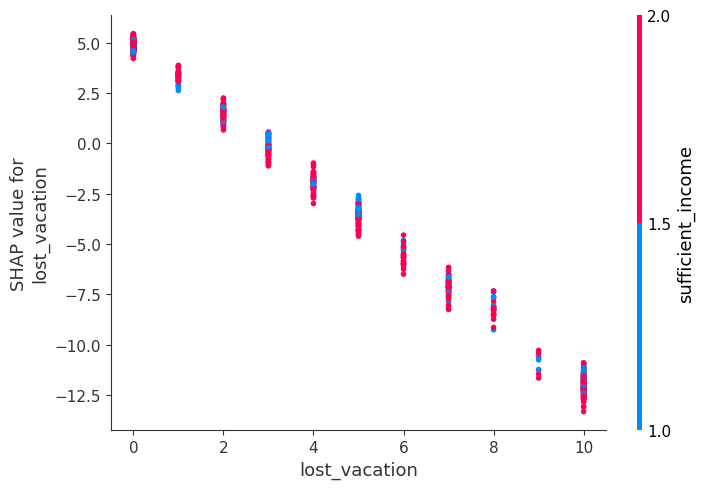

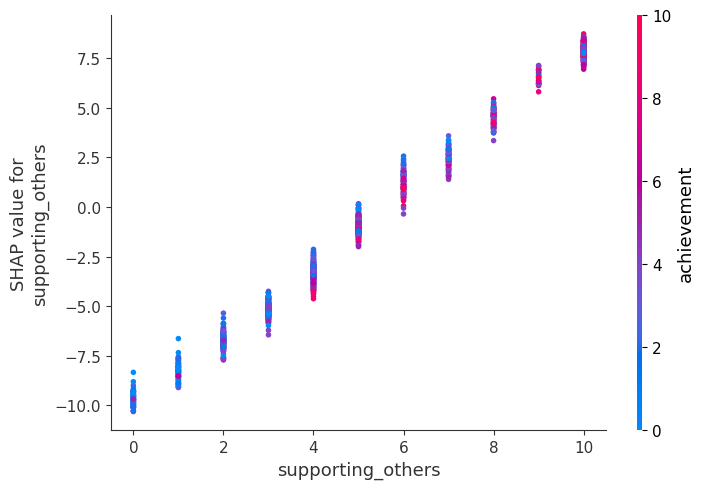

In [55]:
# Dependence plots for top features
top_features = pd.DataFrame({
    'feature': X_val.columns,
    'importance': np.abs(shap_values_val).mean(axis=0)
}).sort_values('importance', ascending=False).head(5)['feature'].tolist()

print(f"\nDependence plots for top 5 features: {top_features}")
for feature in top_features:
    shap.dependence_plot(feature, shap_values_val, X_val, show=False)
    plt.tight_layout()
    plt.show()


## 5) counterfactual



In [36]:
!uv pip install dice-ml

# https://github.com/interpretml/DiCE

Using Python 3.11.13 environment at: c:\Users\hayk_\OneDrive\Desktop\01_python_math_ml_course\ma
Audited 1 package in 1.05s


In [59]:
import dice_ml
from dice_ml import Dice

# Prepare data for DiCE
# Combine features and target for DiCE
train_data = X_train.copy()
train_data[y] = y_train.values

# Create DiCE data object
dice_data = dice_ml.Data(
    dataframe=train_data,
    continuous_features=X_train.columns.tolist(),
    outcome_name=y
)

# Create DiCE model object
# We need to wrap our LightGBM model
class LGBMWrapper:
    def __init__(self, model):
        self.model = model
    
    def predict(self, X):
        return self.model.predict(X, num_iteration=self.model.best_iteration)

wrapped_model = LGBMWrapper(lgb_model)

dice_model = dice_ml.Model(
    model=wrapped_model,
    backend='sklearn',
    model_type='regressor'
)

# Create DiCE explainer
dice_exp = Dice(dice_data, dice_model)

print("DiCE explainer created successfully!")

# Select a sample from validation set with below-average score
sample_idx = y_val[y_val < y_val.mean()].index[0]
query_instance = X_val.loc[[sample_idx]]

print(f"\nOriginal instance (index {sample_idx}):")
print(query_instance.T)
print(f"\nCurrent prediction: {lgb_model.predict(query_instance, num_iteration=lgb_model.best_iteration)[0]:.2f}")
print(f"Target mean score: {y_train.mean():.2f}")

DiCE explainer created successfully!

Original instance (index 13441):
                   13441
fruits_veggies       5.0
daily_stress         5.0
places_visited       0.0
core_circle          3.0
supporting_others    5.0
social_network       4.0
achievement          0.0
donation             0.0
bmi_range            2.0
todo_completed       4.0
flow                 0.0
daily_steps          5.0
live_vision          1.0
sleep_hours          7.0
lost_vacation       10.0
daily_shouting       0.0
sufficient_income    1.0
personal_awards      8.0
time_for_passion     1.0
weekly_meditation    7.0
age                 65.0
gender               0.0

Current prediction: 588.67
Target mean score: 666.45


In [60]:
# Generate counterfactual explanations
# Goal: find similar instances with higher work-life balance score
desired_range = [y_train.mean(), y_train.max()]

dice_result = dice_exp.generate_counterfactuals(
    query_instance,
    total_CFs=3,  # Generate 3 counterfactual examples
    desired_range=desired_range
)

# Display counterfactuals
print("\nCounterfactual Examples:")
dice_result.visualize_as_dataframe(show_only_changes=False)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


Counterfactual Examples:
Query instance (original outcome : 589.0)


,fruits_veggies,daily_stress,places_visited,core_circle,supporting_others,social_network,achievement,donation,bmi_range,todo_completed,...,sleep_hours,lost_vacation,daily_shouting,sufficient_income,personal_awards,time_for_passion,weekly_meditation,age,gender,work_life_balance_score
0,5,5.0,0,3,5,4,0,0,2,4,...,7,10,0,1,8,1,7,65.0,0,589.0



Diverse Counterfactual set (new outcome: [666.4498264869665, 816.4])


,fruits_veggies,daily_stress,places_visited,core_circle,supporting_others,social_network,achievement,donation,bmi_range,todo_completed,...,sleep_hours,lost_vacation,daily_shouting,sufficient_income,personal_awards,time_for_passion,weekly_meditation,age,gender,work_life_balance_score
0,5,5.0,7,10,6,4,0,4,1,1,...,4,10,0,2,8,8,7,65.0,0,666.980530
1,5,2.0,0,10,5,4,0,5,2,4,...,7,0,0,1,8,7,7,65.0,0,673.118713
2,5,0.5,9,3,5,10,0,0,1,4,...,7,10,0,2,8,1,7,64.6,0,667.071960


## 6) LIME Explanations

LIME (Local Interpretable Model-agnostic Explanations) explains individual predictions by approximating the model locally with an interpretable model.

In [ ]:
!uv pip install lime

In [96]:
# Explain a single prediction
# Use the same instance we used for counterfactuals
instance_to_explain = X_val.iloc[X_val.index.get_loc(sample_idx)].values

# Create prediction function for LIME
def predict_fn(X):
    return lgb_model.predict(X, num_iteration=lgb_model.best_iteration)

# Generate explanation
lime_exp = lime_explainer.explain_instance(
    instance_to_explain,
    predict_fn,
    num_features=10
)

print(f"Prediction: {predict_fn(instance_to_explain.reshape(1, -1))[0]:.2f}")
print("\nTop feature contributions:")
lime_exp.as_list()

Prediction: 588.09

Top feature contributions:


[('1.00 < bmi_range <= 2.00', -17.151707014015987),
 ('sufficient_income <= 1.00', -16.770265672492865),
 ('lost_vacation > 5.00', -13.475632251518945),
 ('donation <= 1.00', -9.273886316632264),
 ('places_visited <= 2.00', -9.268194749827487),
 ('fruits_veggies > 4.00', 8.993228046354185),
 ('todo_completed <= 4.00', -8.987199302860178),
 ('social_network <= 4.00', -8.246086117309623),
 ('core_circle <= 3.00', -8.216586721820562),
 ('daily_stress > 4.00', -7.94559297829851)]

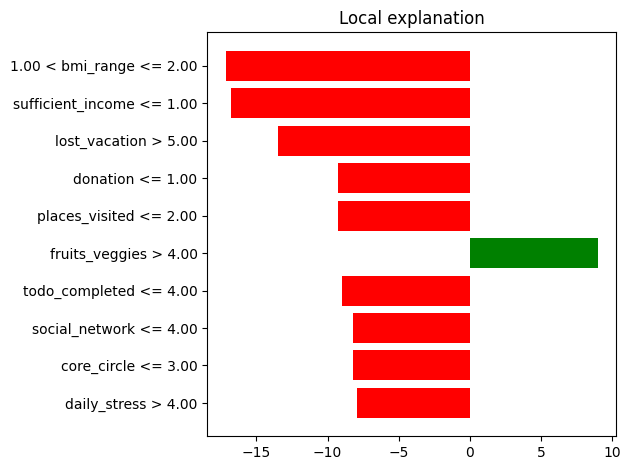

In [97]:
# Visualize the explanation
fig = lime_exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

In [61]:
import time
time.sleep(10)

In [101]:
# Generate LIME explanations for multiple samples to get average feature importance
n_samples = 50  # Number of samples to explain
sample_indices = np.random.choice(X_val.index, size=min(n_samples, len(X_val)), replace=False)

# Collect feature importances
feature_importances = {feature: [] for feature in X_val.columns}

print(f"Generating LIME explanations for {len(sample_indices)} samples...")
for idx in sample_indices:
    instance = X_val.loc[idx].values
    exp = lime_explainer.explain_instance(instance, predict_fn, num_features=len(X_val.columns))
    
    # Extract feature weights
    for feature, weight in exp.as_list():
        # Parse feature name (LIME returns feature with condition)
        for col in X_val.columns:
            if col in feature:
                feature_importances[col].append(abs(weight))
                break

# Calculate mean absolute importance for each feature
mean_importances = {feat: np.mean(vals) if vals else 0 
                    for feat, vals in feature_importances.items()}

# Sort by importance
sorted_features = sorted(mean_importances.items(), key=lambda x: x[1], reverse=True)

print("\nTop 10 Most Important Features (LIME):")
for i, (feature, importance) in enumerate(sorted_features[:10], 1):
    print(f"{i:2d}. {feature:25s}: {importance:.4f}")

Generating LIME explanations for 50 samples...

Top 10 Most Important Features (LIME):
 1. sufficient_income        : 17.0589
 2. bmi_range                : 16.5332
 3. weekly_meditation        : 7.4234
 4. donation                 : 7.1667
 5. supporting_others        : 7.1096
 6. social_network           : 7.0180
 7. lost_vacation            : 6.5323
 8. places_visited           : 6.2484
 9. fruits_veggies           : 6.1162
10. daily_stress             : 6.0299

Top 10 Most Important Features (LIME):
 1. sufficient_income        : 17.0589
 2. bmi_range                : 16.5332
 3. weekly_meditation        : 7.4234
 4. donation                 : 7.1667
 5. supporting_others        : 7.1096
 6. social_network           : 7.0180
 7. lost_vacation            : 6.5323
 8. places_visited           : 6.2484
 9. fruits_veggies           : 6.1162
10. daily_stress             : 6.0299


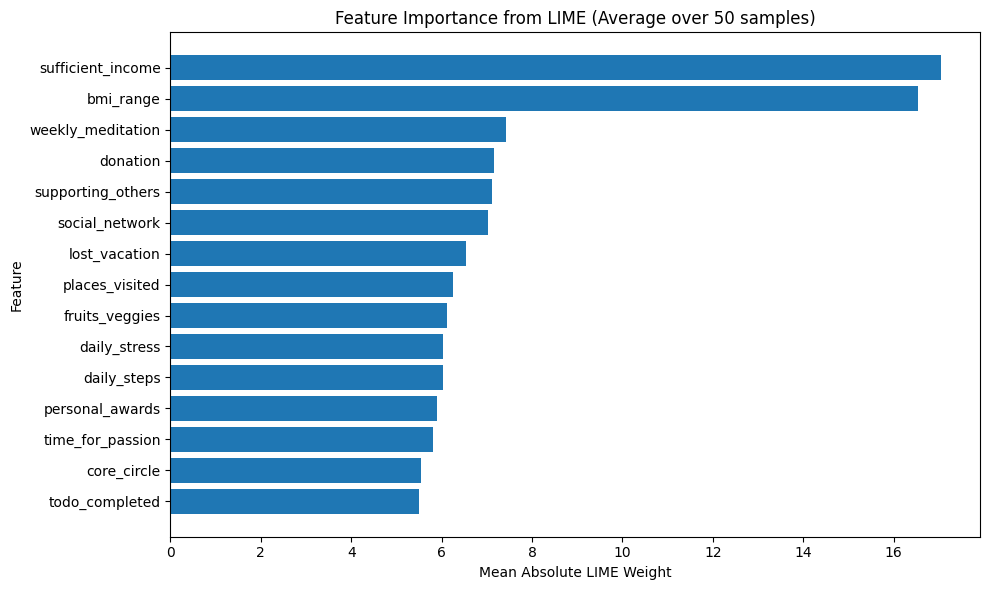

In [102]:
# Visualize feature importances
plt.figure(figsize=(10, 6))
features_to_plot = sorted_features[:15]  # Top 15 features
plt.barh([f[0] for f in features_to_plot], [f[1] for f in features_to_plot])
plt.xlabel('Mean Absolute LIME Weight')
plt.ylabel('Feature')
plt.title('Feature Importance from LIME (Average over 50 samples)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Feature Importance from LIME

Calculate average feature importance across multiple validation samples: